### Training an AI agent to play Pong using DQN (based on the (Mnih 2015) DeepMind paper: Human-level control through deep reinforcement learning)

In [11]:
#!pip install "numpy<2.0" 
#!pip install tensorflow 
#!pip install gymnasium[atari] 
#!pip install ale-py 
#!pip install opencv-python 
#!pip install matplotlib

In [1]:
import random
import collections
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import gymnasium as gym
import ale_py
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import FrameStackObservation
from gymnasium.wrappers import RecordVideo

from IPython.display import display, clear_output

#### Visualising the game

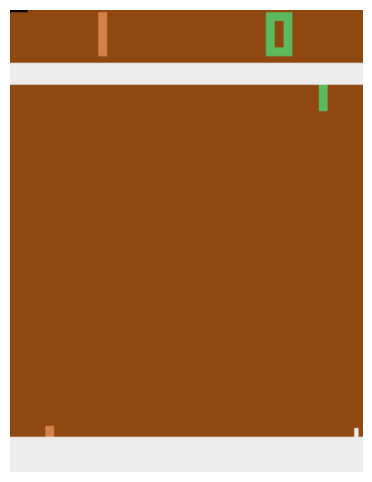

In [2]:
gym.register_envs(ale_py)

# Create a Pong environment with visual rendering for demo
env_vis = gym.make("ALE/Pong-v5", render_mode="rgb_array")

obs, info = env_vis.reset(seed=42)

# Take a random action until one play wins a point
plt.figure(figsize=(6, 6))
for step in range(100):
    frame = env_vis.render()  # RGB frame from environment

    plt.imshow(frame)
    plt.axis("off")
    display(plt.gcf())
    clear_output(wait=True)

    # Random action just to see movement
    action = env_vis.action_space.sample()
    obs, reward, terminated, truncated, info = env_vis.step(action)

    if terminated or truncated:
        obs, info = env_vis.reset()

env_vis.close()
plt.close()

#### Replay Buffer, DQN Agent and environment intialisation

In [2]:

# ---------- Replay Buffer ----------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    # Store an experience
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    # Get a random sample of experiences
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert frame from unit8 to float32
        states = np.array(states, dtype=np.uint8).astype(np.float32) / 255.0
        next_states = np.array(next_states, dtype=np.uint8).astype(np.float32) / 255.0
        
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int32),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32),
        )

    def __len__(self):
        return len(self.buffer)

# ---------- DQN Agent ----------
class Agent:
    def __init__(self, q_net = None, learning_rate = 1e-4, gamma = 0.99, eps_min=0.1, decay_steps=150_000):

        self.gamma = gamma
        self.eps_min = eps_min
        self.decay_steps = decay_steps
        
        # Build networks and components
        if q_net is not None:
            self.q_net = q_net
        else:
            self.q_net = self.build_q_network(num_actions)
        
        self.target_net = self.build_q_network(num_actions)
        self.target_net.set_weights(self.q_net.get_weights())

        # Create the optimiser
        self.optimizer = keras.optimizers.Adam(learning_rate, clipnorm=10.0)
        self.optimizer.build(self.q_net.trainable_variables)

        self.huber = tf.keras.losses.Huber()

    # ---------- Q-network (DQN) ----------
    def build_q_network(self, num_actions):

        # Build the DQN network (as per Mnih, 2015)
        model = keras.Sequential([

            # Pass the stacked frames through 3 convolutional layers
            layers.Input(shape=(84, 84, 4)),  # channels-last (H,W,C)
            layers.Conv2D(32, 8, strides=4, activation="relu"),
            layers.Conv2D(64, 4, strides=2, activation="relu"),
            layers.Conv2D(64, 3, strides=1, activation="relu"),
    
            # Pass through a fully connected layer and output actions as probabilities
            layers.Flatten(),
            layers.Dense(512, activation="relu"),
            layers.Dense(num_actions)  # Q-values for each action
        ])
        return model

    # ---------- ε-greedy schedule (as per Mnih, 2015) ----------
    def epsilon_by_step(self, step):
        if step >= self.decay_steps:
            return self.eps_min
        frac = step / self.decay_steps
        return 1.0 + frac * (self.eps_min - 1.0)  # linear decay from 1.0 -> eps_min
        
    # ---------- select an action based on epsilon ----------
    def select_action(self, state, epsilon, num_actions):
        # state: (84,84,4)
        if random.random() < epsilon:
            return random.randrange(num_actions)
        state_tf = tf.convert_to_tensor(state[None, ...], dtype=tf.float32)  # (1,84,84,4)
        q_values = self.q_net(state_tf, training=False)[0]  # (num_actions,)
        return int(tf.argmax(q_values).numpy())

    # ---------- train the model ----------
    @tf.function
    def train_step(self, states_tf, actions_tf, rewards_tf, next_states_tf, dones_tf):
        
        with tf.GradientTape() as tape:
            q_values = self.q_net(states_tf, training=True)
            q_s_a = tf.reduce_sum(q_values * tf.one_hot(actions_tf, num_actions), axis=1)
            
            max_next_q = tf.reduce_max(self.target_net(next_states_tf, training=False), axis=1)
            targets = tf.stop_gradient(rewards_tf + self.gamma * (1.0 - dones_tf) * max_next_q)

            # Use the Huber loss function
            loss = self.huber(targets, q_s_a)
    
        grads = tape.gradient(loss, self.q_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_net.trainable_variables))
        return loss

    # ---------- Update the target weights based on the q_net weights ----------
    def update_target_net(self):
        self.target_net.set_weights(self.q_net.get_weights())
        
    # ---------- Save a snap shot of the model  ----------
    def save_model_snapshot(self, file_prefix, step):
        self.q_net.save(f"./model_snapshots/{file_prefix}_pong_dqn ({step} steps).keras")



# ---------- Initialise the Pong environment ----------
def initialise_environment(env_name = "ALE/Pong-v5", record_video = False, video_name_prefix=""):
    
    class ChannelsLast(gym.ObservationWrapper):
        def observation(self, obs):
            # (4,84,84) -> (84,84,4)
            return np.transpose(obs, (1, 2, 0))

    if record_video:
        # Create Pong env for recording
        env = gym.make(env_name, render_mode="rgb_array", frameskip=1)
        env = RecordVideo(
            env.unwrapped,
            video_folder="./videos",
            episode_trigger=lambda e: True,
            name_prefix=video_name_prefix
        )
    else:    
        # Create Pong env for training (no rendering here)
        env = gym.make(env_name, render_mode=None, frameskip=1, full_action_space=False)
    
    env = AtariPreprocessing(env, noop_max=30, frame_skip=4, screen_size=84, grayscale_obs=True, scale_obs=False)
    env = FrameStackObservation(env, stack_size=4)
    env = ChannelsLast(env)
    return env



#### Train agent

In [3]:
start_time = time.time()

# Create an environment for training
env = initialise_environment(env_name = "ALE/Pong-v5")
state, info = env.reset(seed=42)
num_actions = env.action_space.n

# initialise the replay buffer
replay_buffer = ReplayBuffer(capacity=200_000)

file_prefix = "batch8"
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = 1_000   # update the target network after x steps
WARMUP_STEPS = 50_000         # collect some data before learning
TOTAL_STEPS = 4_000_001       # training length

# initialise the agent for training
agent = Agent(learning_rate = 5e-5, gamma = 0.99, eps_min=0.1, decay_steps=150_000)

# Save the model after this many steps
save_model_steps = {0, 50_000, 100_000, 250_000, 500_000, 750_000, 1_000_000, 1_500_000, 2_000_000, 2_500_000, 3_000_000, 3_500_000, 4_000_000}

episode_reward = 0.0
episode_rewards = []
episode_end_steps = []

step_time = 0.0
sample_time = 0.0
dqn_update_time = 0.0


for step in range(TOTAL_STEPS):
    # ---- ε-greedy action selection ----
    epsilon = agent.epsilon_by_step(step)
    action = agent.select_action(state, epsilon, num_actions)

    # ---- env step ----
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # ---- store transition ----
    replay_buffer.push(state, action, float(reward), next_state, float(done))
    state = next_state
    episode_reward += reward

    # ---- handle episode end ----
    if done:
        state, info = env.reset()
            
        episode_rewards.append(episode_reward)
        episode_end_steps.append(step)
        print(f"[Step {step}] Episode finished, reward = {episode_reward}")
        episode_reward = 0.0

    # ---- save the model at certain check point ----
    if step in save_model_steps:
        agent.save_model_snapshot(file_prefix, step)

    # ---- warmup: no learning yet ----
    if step < WARMUP_STEPS or len(replay_buffer) < BATCH_SIZE:
        continue

    # ---- sample minibatch ----
    states_b, actions_b, rewards_b, next_states_b, dones_b = replay_buffer.sample(BATCH_SIZE)

    # tf.config.run_functions_eagerly(False)
    states_tf      = tf.convert_to_tensor(states_b, tf.float32)
    actions_tf     = tf.convert_to_tensor(actions_b, tf.int32)
    rewards_tf     = tf.convert_to_tensor(rewards_b, tf.float32)
    next_states_tf = tf.convert_to_tensor(next_states_b, tf.float32)
    dones_tf       = tf.convert_to_tensor(dones_b, tf.float32)
    
    loss = agent.train_step(states_tf, actions_tf, rewards_tf, next_states_tf, dones_tf)

    # ---- periodically update target network ----
    if step % TARGET_UPDATE_FREQ == 0:
        agent.update_target_net()
        print(f"[Step {step}] loss = {loss.numpy():.4f}, epsilon = {epsilon:.3f}")

env.close()

# ---------- SAVE TRAINED MODEL + LOGS ----------
np.save(f"{file_prefix}_pong_episode_rewards.npy", np.array(episode_rewards))
np.save(f"{file_prefix}_pong_episode_end_steps.npy", np.array(episode_end_steps))

# --------- PRINT TIME TAKEN ------------
end_time = time.time()
total_seconds = end_time - start_time

hours = int(total_seconds // 3600)
minutes = int((total_seconds % 3600) // 60)
seconds = int(total_seconds % 60)

print("TRAINING COMPLETE")
print(f"Time Taken: {hours}h {minutes}m {seconds}s")
print("===================================")

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


[Step 1185] Episode finished, reward = -20.0
[Step 2021] Episode finished, reward = -21.0
[Step 2933] Episode finished, reward = -20.0
[Step 3752] Episode finished, reward = -21.0
[Step 4682] Episode finished, reward = -21.0
[Step 5522] Episode finished, reward = -20.0
[Step 6584] Episode finished, reward = -20.0
[Step 7579] Episode finished, reward = -21.0
[Step 8402] Episode finished, reward = -21.0
[Step 9162] Episode finished, reward = -21.0
[Step 10298] Episode finished, reward = -20.0
[Step 11259] Episode finished, reward = -19.0
[Step 12155] Episode finished, reward = -20.0
[Step 12979] Episode finished, reward = -21.0
[Step 13738] Episode finished, reward = -21.0
[Step 14703] Episode finished, reward = -21.0
[Step 15724] Episode finished, reward = -20.0
[Step 16696] Episode finished, reward = -19.0
[Step 17720] Episode finished, reward = -19.0
[Step 18774] Episode finished, reward = -18.0
[Step 19766] Episode finished, reward = -20.0
[Step 20818] Episode finished, reward = -19.

### Generate plot to visualize learning

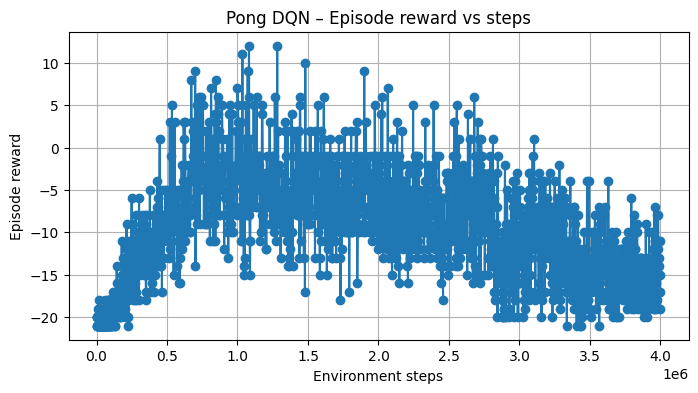

In [4]:
# episode_rewards = np.load("pong_episode_rewards.npy").tolist() - to access later
# episode_end_steps = np.load("pong_episode_end_steps.npy").tolist()


episode_rewards_arr = np.array(episode_rewards)
episode_end_steps_arr = np.array(episode_end_steps)

plt.figure(figsize=(8, 4))
plt.plot(episode_end_steps_arr, episode_rewards_arr, marker="o", linestyle="-")
plt.xlabel("Environment steps")
plt.ylabel("Episode reward")
plt.title("Pong DQN – Episode reward vs steps")
plt.grid(True)
plt.show()

### Save videos based on model snapshots

In [10]:
# For each model snapshot
for step in sorted(save_model_steps):

    # Load the saved network
    
    file_name = f"{file_prefix}_pong_dqn ({step} steps)"
    try:
        print("Saving video for " + file_name)
        q_net = keras.models.load_model(f"./model_snapshots/{file_name}.keras")

        agent = Agent(q_net=q_net)

        # Initialise the environment for rendering
        env = initialise_environment(record_video = True, video_name_prefix=file_name)
        state, info = env.reset()
        num_actions = env.action_space.n
        
        # Record a video of the network
        done = False
        total_reward = 0
        
        while not done:
            # Greedy policy from trained agent
            action = agent.select_action(state, epsilon=0.0, num_actions=num_actions)
        
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
                    
        env.close()

    except ValueError:
        print("Couldn't load " + file_name)
        break

Saving video for batch8_pong_dqn (0 steps)


/opt/miniconda3/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/davidhood/Documents/BathRLProject2025/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Saving video for batch8_pong_dqn (50000 steps)


/opt/miniconda3/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/davidhood/Documents/BathRLProject2025/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Saving video for batch8_pong_dqn (100000 steps)
Saving video for batch8_pong_dqn (250000 steps)
Saving video for batch8_pong_dqn (500000 steps)
Saving video for batch8_pong_dqn (750000 steps)
Saving video for batch8_pong_dqn (1000000 steps)
Saving video for batch8_pong_dqn (1500000 steps)
Saving video for batch8_pong_dqn (2000000 steps)
Saving video for batch8_pong_dqn (2500000 steps)
Saving video for batch8_pong_dqn (3000000 steps)
Saving video for batch8_pong_dqn (3500000 steps)
Saving video for batch8_pong_dqn (4000000 steps)


### Evaluate agents based on model snapshots

In [9]:
try:
    step = 1_000_000
    file_name = f"./model_snapshots/{file_prefix}_pong_dqn ({step} steps)"
    print("Evaluating agent for " + file_name)
    q_net = keras.models.load_model(f"{file_name}.keras")
    agent = Agent(q_net=q_net)

    # Initialise the environment for rendering
    env = initialise_environment()
    total_reward = 0
    episode_count = 36
    rewards = [] # np.zeros(episode_count, dtype=np.float32)
    for i in range(episode_count):
        print(f"Playing episode {i}", end="")
        done = False
        state, info = env.reset()
        num_actions = env.action_space.n

        rewards.append(0)
        while not done:
            # Greedy policy from trained agent
            action = agent.select_action(state, epsilon=0.0, num_actions=num_actions)
        
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
            rewards[i] += reward

        print(f", reward: {rewards[i]:.2f}")
    print(f"Reward: {np.mean(rewards):.2f} +/-{np.std(rewards):.2f}")
    env.close()

except ValueError:
    print("Couldn't load " + file_name)
    

Evaluating agent for ./model_snapshots/batch8_pong_dqn (1000000 steps)
Playing episode 0, reward: 10.00
Playing episode 1, reward: 5.00
Playing episode 2, reward: -1.00
Playing episode 3, reward: 5.00
Playing episode 4, reward: 9.00
Playing episode 5, reward: 13.00
Playing episode 6, reward: 4.00
Playing episode 7, reward: 7.00
Playing episode 8, reward: 10.00
Playing episode 9, reward: 15.00
Playing episode 10, reward: 13.00
Playing episode 11, reward: 11.00
Playing episode 12, reward: 4.00
Playing episode 13, reward: 12.00
Playing episode 14, reward: 7.00
Playing episode 15, reward: 11.00
Playing episode 16, reward: -1.00
Playing episode 17, reward: 5.00
Playing episode 18, reward: 10.00
Playing episode 19, reward: 14.00
Playing episode 20, reward: 6.00
Playing episode 21, reward: 11.00
Playing episode 22, reward: 8.00
Playing episode 23, reward: 10.00
Playing episode 24, reward: 7.00
Playing episode 25, reward: 12.00
Playing episode 26, reward: 11.00
Playing episode 27, reward: 9.00